# 🍄 SVM Mushroom Classification — Notebook

This notebook performs the full pipeline: EDA, visualizations, preprocessing, SVM training, evaluation, hyperparameter tuning, and saving outputs.

**Important:** Put the dataset at `data/mushroom.csv` (relative to this notebook).

## 🔧 Setup (imports & folders)

In [1]:

# Setup imports and folders
import os, warnings, pickle
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style='whitegrid')

# Use a relative, portable data path
DATA_PATH = os.path.join("data", "mushroom.csv")

PROJECT_ROOT = os.getcwd()
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "output")
GRAPH_DIR = os.path.join(OUTPUT_DIR, "graphs")
REPORT_DIR = os.path.join(OUTPUT_DIR, "reports")
MODEL_DIR = os.path.join(PROJECT_ROOT, "models")

os.makedirs(GRAPH_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Environment ready.")
print("Expecting dataset at:", DATA_PATH)


Environment ready.
Expecting dataset at: data\mushroom.csv


## 1. Load dataset

In [2]:

# Load the dataset (will raise FileNotFoundError if not present)
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape, "rows x columns")
df.head()


Loaded: (2000, 26) rows x columns


,Unnamed: 0,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat,class,stalk_height,cap_diameter
0,1167,sunken,scaly,white,no,anise,descending,distant,broad,pink,...,partial,brown,two,sheathing,chocolate,clustered,waste,poisonous,14.276173,5.054983
1,1037,sunken,fibrous,red,no,anise,notched,crowded,narrow,chocolate,...,universal,brown,two,sheathing,brown,numerous,waste,edible,3.952715,19.068319
2,309,flat,grooves,purple,yes,foul,descending,crowded,broad,purple,...,universal,yellow,two,sheathing,purple,abundant,waste,poisonous,9.054265,7.205884
3,282,bell,scaly,pink,yes,fishy,notched,close,broad,orange,...,partial,yellow,two,cobwebby,green,clustered,grasses,poisonous,5.226499,20.932692
4,820,flat,smooth,yellow,yes,musty,free,crowded,narrow,orange,...,universal,white,none,none,yellow,clustered,urban,poisonous,14.037532,12.545245


## 2. Exploratory Data Analysis

In [3]:

print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nClass distribution (e = edible, p = poisonous):")
print(df['class'].value_counts())


Columns: ['Unnamed: 0', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat', 'class', 'stalk_height', 'cap_diameter']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2000 non-null   int64  
 1   cap_shape                 2000 non-null   object 
 2   cap_surface               2000 non-null   object 
 3   cap_color                 2000 non-null   object 
 4   bruises                   2000 non-null   object 
 5   odor                      2000 non-null   object 
 6   gill_attachment 

None


Missing values:
Unnamed: 0                  0
cap_shape                   0
cap_surface                 0
cap_color                   0
bruises                     0
odor                        0
gill_attachment             0
gill_spacing                0
gill_size                   0
gill_color                  0
stalk_shape                 0
stalk_root                  0
stalk_surface_above_ring    0
stalk_surface_below_ring    0
stalk_color_above_ring      0
stalk_color_below_ring      0
veil_type                   0
veil_color                  0
ring_number                 0
ring_type                   0
spore_print_color           0
population                  0
habitat                     0
class                       0
stalk_height                0
cap_diameter                0
dtype: int64

Class distribution (e = edible, p = poisonous):
class
poisonous    1400
edible        600
Name: count, dtype: int64


## 3. Visualizations (saved to output/graphs)

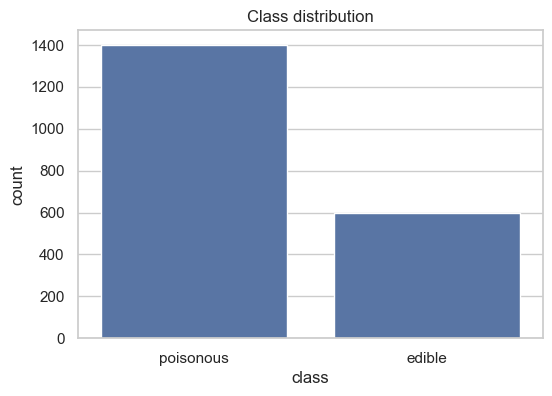

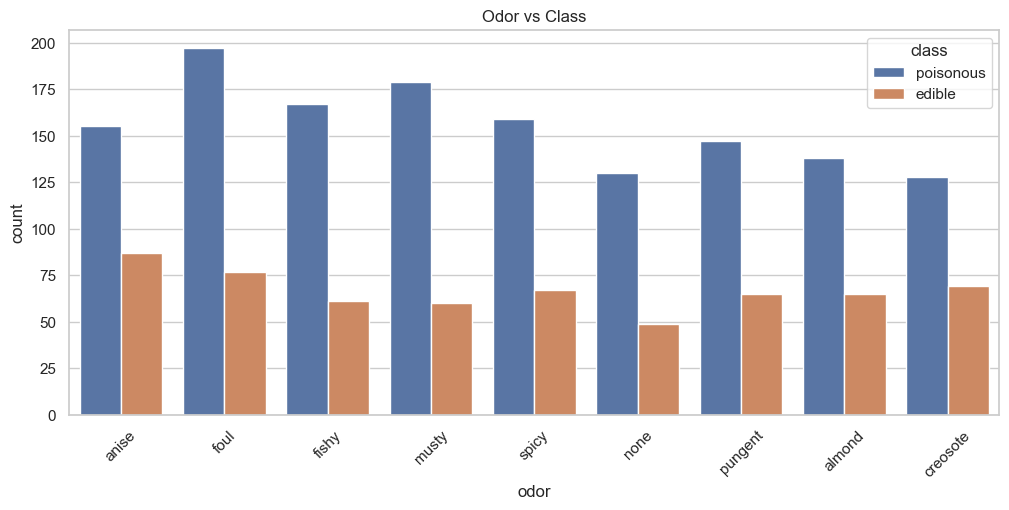

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df)
plt.title("Class distribution")
plt.savefig(os.path.join(GRAPH_DIR, "class_distribution.png"), bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(x='odor', hue='class', data=df)
plt.title("Odor vs Class")
plt.xticks(rotation=45)
plt.savefig(os.path.join(GRAPH_DIR, "odor_vs_class.png"), bbox_inches='tight', dpi=150)
plt.show()


## 4. Preprocessing (Label Encoding + Train/Test split)

In [5]:

# Encode categorical columns to numeric
df_enc = df.copy()
le = LabelEncoder()
for col in df_enc.columns:
    df_enc[col] = le.fit_transform(df_enc[col])

# Prepare features and label
X = df_enc.drop('class', axis=1)
y = df_enc['class']

# Stratified split to keep class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)


Shapes:
X_train: (1600, 25) X_test: (400, 25)


## 5. Correlation (on encoded data)

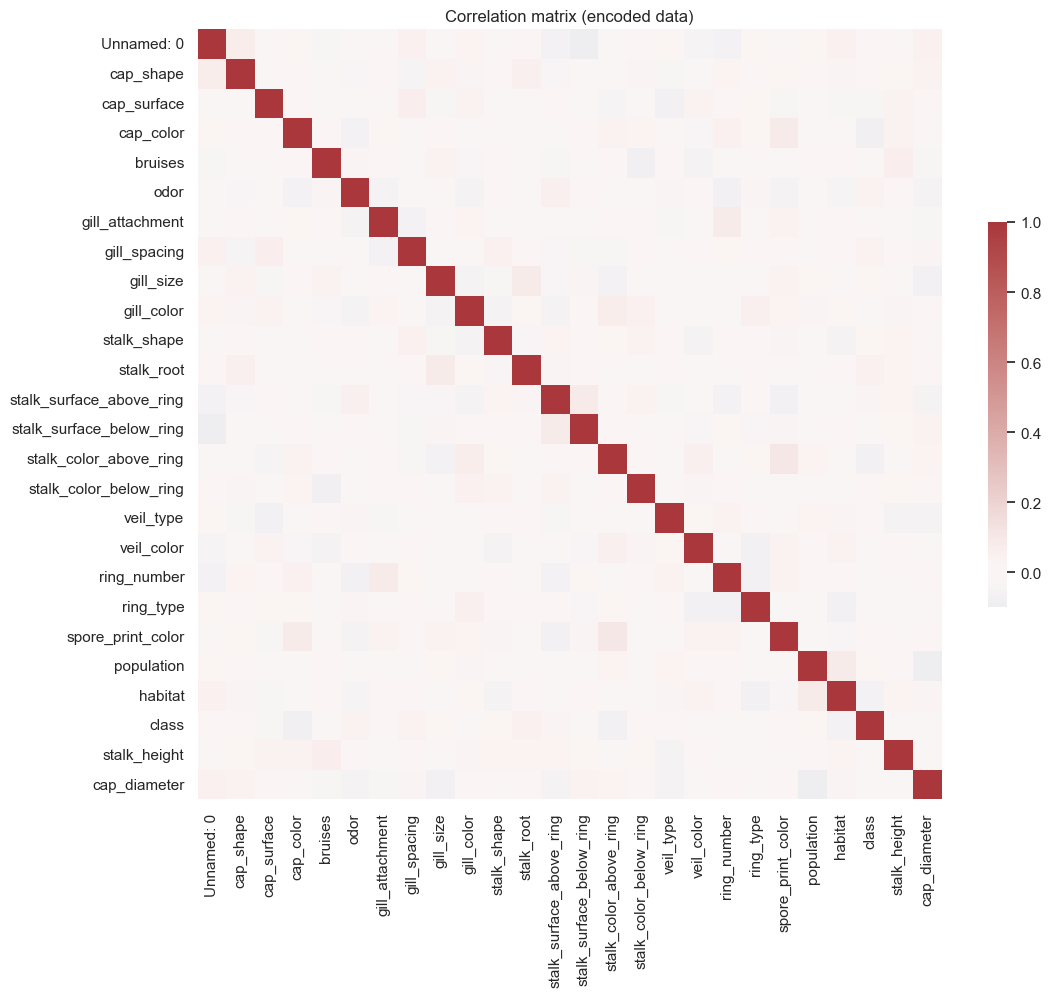

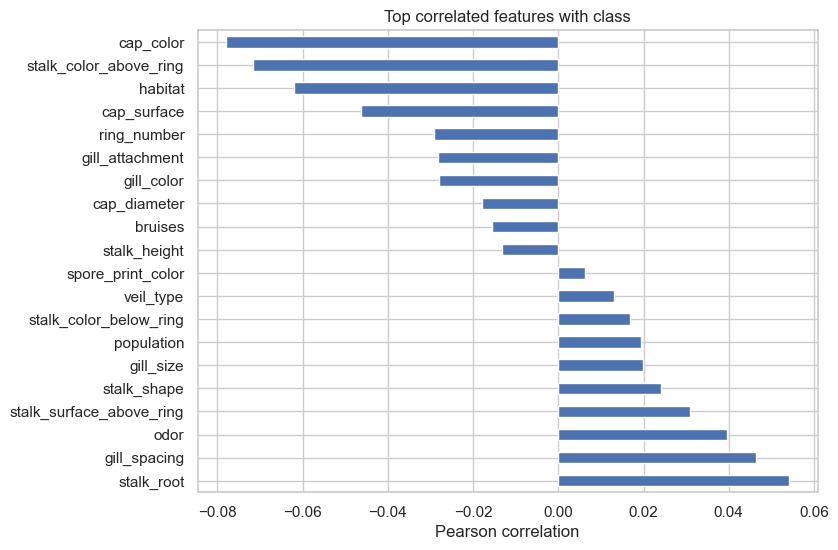

In [6]:

plt.figure(figsize=(12,10))
sns.heatmap(df_enc.corr(), cmap='vlag', center=0, cbar_kws={'shrink':0.5})
plt.title("Correlation matrix (encoded data)")
plt.savefig(os.path.join(GRAPH_DIR, "correlation_matrix.png"), bbox_inches='tight', dpi=150)
plt.show()

# Top features correlated with target
corr_with_target = df_enc.corr()['class'].drop('class').sort_values(ascending=False)
top_combined = pd.concat([corr_with_target.head(10), corr_with_target.tail(10)])
plt.figure(figsize=(8,6))
top_combined.plot(kind='barh')
plt.title("Top correlated features with class")
plt.xlabel("Pearson correlation")
plt.gcf().savefig(os.path.join(GRAPH_DIR, "top_correlated_with_class.png"), bbox_inches='tight', dpi=150)
plt.show()


## 6. Train SVM (RBF kernel)

In [7]:

svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", acc)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", report)

# Save evaluation report
with open(os.path.join(REPORT_DIR, "svm_evaluation.txt"), "w") as f:
    f.write(f"ACCURACY: {acc:.4f}\n\n")
    f.write("CONFUSION MATRIX:\n")
    f.write(str(cm) + "\n\n")
    f.write("CLASSIFICATION REPORT:\n")
    f.write(report)

# Save model
with open(os.path.join(MODEL_DIR, "svm_model.pkl"), "wb") as f:
    pickle.dump(svm, f)

print("Evaluation report and model saved.")


Accuracy: 0.7

Confusion matrix:
 [[  0 120]
 [  0 280]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.70      1.00      0.82       280

    accuracy                           0.70       400
   macro avg       0.35      0.50      0.41       400
weighted avg       0.49      0.70      0.58       400

Evaluation report and model saved.


## 7. Hyperparameter tuning (GridSearchCV)

In [8]:

param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best = grid.best_estimator_
y_pred_best = best.predict(X_test)
print("\nTest accuracy (best):", accuracy_score(y_test, y_pred_best))
print("\nConfusion matrix (best):\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification report (best):\n", classification_report(y_test, y_pred_best))

# Save gridsearch report
with open(os.path.join(REPORT_DIR, "gridsearch_report.txt"), "w") as f:
    f.write("Best params: " + str(grid.best_params_) + "\n")
    f.write("Best CV score: " + str(grid.best_score_) + "\n")
    f.write("\nTest accuracy (best): " + str(accuracy_score(y_test, y_pred_best)) + "\n")
    f.write("\nDetailed classification report:\n")
    f.write(classification_report(y_test, y_pred_best))
print("GridSearch report saved.")


Best params: {'C': 0.1, 'kernel': 'linear'}
Best CV score: 0.69999976577121

Test accuracy (best): 0.7

Confusion matrix (best):
 [[  0 120]
 [  0 280]]

Classification report (best):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.70      1.00      0.82       280

    accuracy                           0.70       400
   macro avg       0.35      0.50      0.41       400
weighted avg       0.49      0.70      0.58       400

GridSearch report saved.


## 8. Output files generated

In [9]:

print("Files in output/reports:")
for root, dirs, files in os.walk(REPORT_DIR):
    for name in files:
        print(os.path.join(root, name))

print("\nFiles in output/graphs:")
for root, dirs, files in os.walk(GRAPH_DIR):
    for name in files:
        print(os.path.join(root, name))

print("\nSaved models:")
for root, dirs, files in os.walk(MODEL_DIR):
    for name in files:
        print(os.path.join(root, name))


Files in output/reports:
d:\Projectes\Data-Science\Assignments\SVM\output\reports\gridsearch_report.txt
d:\Projectes\Data-Science\Assignments\SVM\output\reports\svm_evaluation.txt

Files in output/graphs:
d:\Projectes\Data-Science\Assignments\SVM\output\graphs\class_distribution.png
d:\Projectes\Data-Science\Assignments\SVM\output\graphs\correlation_matrix.png
d:\Projectes\Data-Science\Assignments\SVM\output\graphs\odor_vs_class.png
d:\Projectes\Data-Science\Assignments\SVM\output\graphs\top_correlated_with_class.png

Saved models:
d:\Projectes\Data-Science\Assignments\SVM\models\svm_model.pkl
